# Gemma vs Gemma2

## import libraries

In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scikit_posthocs as sp
import utils

from dotenv import load_dotenv
from generator.generator import Generator
from datasets import load_dataset

load_dotenv('env/var.env')

gemma = Generator(model='gemma')
gemma2 = Generator(model='gemma2')

## Load Q&A Data

In [2]:
squad = load_dataset("squad", split="train")
squad = squad.shuffle()

## Create dictionary to save metrics

In [3]:
gemma_metrics = {
    "words_per_second": [],
    "words": [],
    "rank": [],
}

gemma2_metrics = {
    "words_per_second": [],
    "words": [],
    "rank": [],
}

## Gather metrics

In [ ]:
for i in range(100):
    context = squad[i]['context']
    query = squad[i]['question']
    answer = squad[i]['answers']['text'][0]

    # gemma
    answer_gemma, words_per_second, words = utils.get_llm_response(gemma, context, query)
    gemma_metrics["words_per_second"].append(words_per_second)
    gemma_metrics["words"].append(words)
    
    # gemma2
    answer_gemma2, words_per_second, words = utils.get_llm_response(gemma2, context, query)
    gemma2_metrics["words_per_second"].append(words_per_second)
    gemma2_metrics["words"].append(words)
    
    # GPT-3.5 rank
    llm_answers_dict = {'gemma': answer_gemma, 'gemma2': answer_gemma2}
    rank = utils.get_gpt_rank(answer, llm_answers_dict, os.getenv('OPENAI_KEY'))
    if '1' not in rank and '2' in rank:
        rank.insert(1, '1')
    elif '2' not in rank and '1' in rank:
        rank.insert(1, '2')
    elif '1' not in rank and '2' not in rank:
        continue
    gemma_metrics["rank"].append(rank.index('1')+1)
    gemma2_metrics["rank"].append(rank.index('2')+1)

## Metrics comparison

### Gemma vs Gemma2

In [5]:
gemma_metrics = pd.DataFrame(gemma_metrics)
gemma_metrics['model'] = 'Gemma 7B'

gemma2_metrics = pd.DataFrame(gemma2_metrics)
gemma2_metrics['model'] = 'Gemma 2 9B'

# create single data frame for plotting
metrics = pd.concat([gemma_metrics, gemma2_metrics])

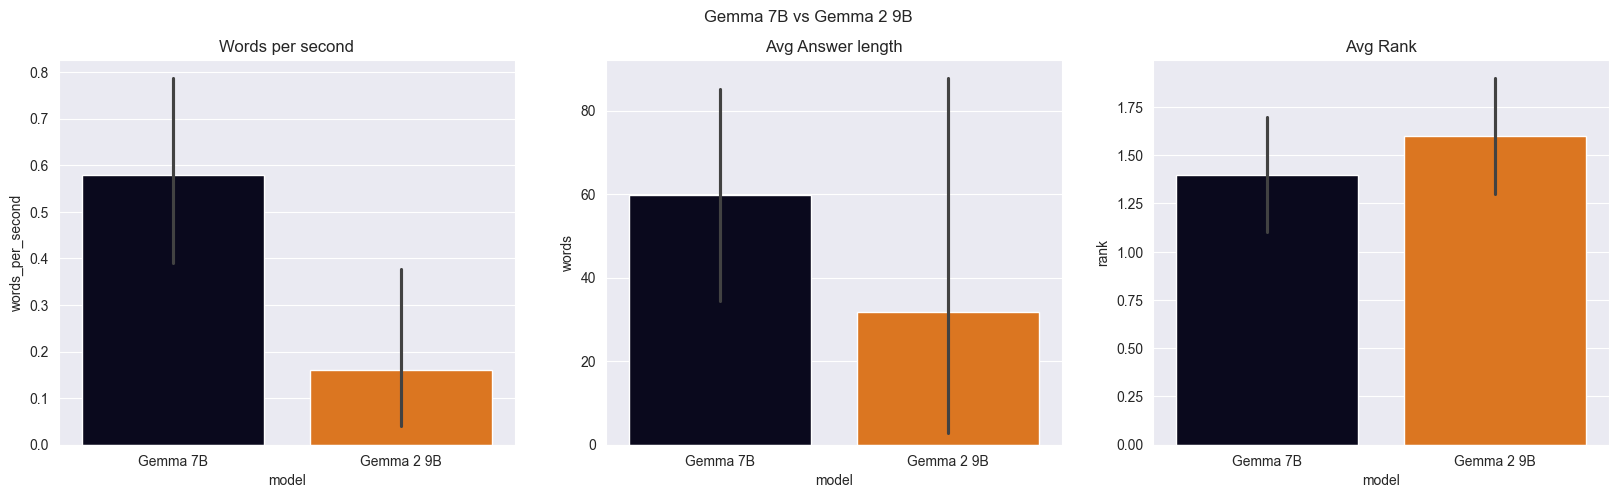

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Gemma 7B vs Gemma 2 9B')

sns.barplot(ax=axes[0], data=metrics, y='words_per_second', x='model', hue='model', palette=["#070620", "#fa7302"])
axes[0].set_title("Words per second")

sns.barplot(ax=axes[1], data=metrics, y='words', x='model', hue='model', palette=["#070620", "#fa7302"])
axes[1].set_title("Avg Answer length")

sns.barplot(ax=axes[2], data=metrics, y='rank', x='model', hue='model', palette=["#070620", "#fa7302"])
axes[2].set_title("Avg Rank")

plt.show()

# Statiscal Test

 - Check if p_values are higher than the level of significance:
      - false means that two groups are statistically different.

In [7]:
p_values = sp.posthoc_dunn([gemma_metrics['rank'], gemma2_metrics['rank']], p_adjust='holm')
p_values > 0.05

,1,2
1,True,True
2,True,True
